In [338]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [339]:
import sys, os
import pandas as pd
from datetime import date

pd.get_option("display.max_rows",100)
'''/home/alonshp/.conda/envs/tf-env/bin/python'''

# sys.path.append(os.path.abspath('../'))
# print(sys.path)

'/home/alonshp/.conda/envs/tf-env/bin/python'

In [468]:
from percantage_replicates_utils import *
# from constants import *
from metrics import *

In [469]:
new_exp = False

if new_exp:
    today = date.today()
    date = today.strftime("%d_%m")
    date
else:
    date = '29_05'

# Load data

In [470]:
ds_info_dict={'CDRP':['CDRP-BBBC047-Bray',['Metadata_Sample_Dose','pert_sample_dose']],
              'CDRP-bio':['CDRPBIO-BBBC036-Bray',['Metadata_Sample_Dose','pert_sample_dose']],
              'TAORF':['TA-ORF-BBBC037-Rohban',['Metadata_broad_sample','pert_id',]],
              'LUAD':['LUAD-BBBC041-Caicedo',['x_mutation_status','allele']],
              'LINCS':['LINCS-Pilot1',['Metadata_pert_id_dose','pert_id_dose']]}

################################################
# dataset options: 'CDRP' , 'LUAD', 'TAORF', 'LINCS', 'CDRP-bio'
# datasets=['LUAD','TAORF','LINCS','CDRP-bio'];
# datasets=['LINCS', 'CDRP-bio','CDRP'];
# datasets=['TAORF','LUAD','LINCS', 'CDRP-bio']
datasets=['CDRP-bio']
# DT_kfold={'LUAD':10, 'TAORF':5, 'LINCS':25, 'CDRP-bio':6,'CDRP':40}


methods = {
    # '4to1':{'path':f'/storage/users/g-and-n/tabular_models_results/41/ALL/zscores'},
    # '2to1':{'path':f'/storage/users/g-and-n/tabular_models_results/21/ALL/zscores'},
    'anomaly':{'name':'anomaly','path':os.path.join(output_dir,'out_ad_treated_zscores.csv')},
    'raw':{'name':'raw','path': os.path.join(output_dir,'input_data_test_treat_zscores.csv')},
    # '5to5':{'path':f'/storage/users/g-and-n/tabular_models_results/55/ALL/zscores'},
}

# from IPython.display import clear_output
################################################
# CP Profile Type options: 'augmented', 'augmented_after_fs' , 'normalized', 'normalized_variable_selected'
profileType='augmented'
profileType ='normalized_variable_selected'
base_dir= '/sise/assafzar-group/assafzar/genesAndMorph'
data_dir=base_dir+'/preprocessed_data/'+ds_info_dict[datasets[0]][0]+'/'
output_dir = f'{base_dir}/anomaly_output/{datasets[0]}/{profileType}'  
save_base_dir = f'{base_dir}/results/{datasets[0]}/{profileType}/'
exp_save_dir = f'{save_base_dir}/{date}'
exp_name= 'autoencoder'

os.makedirs(save_base_dir,exist_ok=True)
os.makedirs(exp_save_dir,exist_ok=True)



In [471]:
new_ss = True
ss_calc = 'median'
num_rand = 1000

null_dist_path = f'{output_dir}/null_distribution_replicates_{num_rand}.pkl'

null_distribution_medians_base_path = f'{output_dir}/null_distribution_medians_{num_rand}'

In [472]:
def set_index_fields(df, index_fields=None):

    if index_fields is None:
        index_fields = ['Metadata_Plate', 'Metadata_ASSAY_WELL_ROLE', 'Metadata_broad_sample', 'Metadata_Well',
                        'Metadata_mmoles_per_liter']
    df = df.set_index(
        index_fields)
    return df


In [473]:
for m in methods.keys():
    
    zscores = pd.read_csv(methods[m]['path'], compression = 'gzip')
    
    methods[m]['features'] = zscores.columns[zscores.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")]
    zscores = set_index_fields(zscores)
    methods[m]['zscores'] = zscores.loc[:,methods[m]['features']]

In [474]:
num_features = len(methods['anomaly']['features'])

len(methods['anomaly']['features']),len(methods['raw']['features'])

(574, 574)

# Plot sensitivity and complementry

In [348]:
def extract_ss_score(df, th_range=[2, 6, 10, 14], cpd_id_fld='Metadata_broad_sample',new_ss = True, value='mean',abs_zscore=False):
    if new_ss:
        print(f'calc with {value}')
        cur_res = df.groupby(cpd_id_fld).apply(extract_new_score_for_compound, abs_zscore=abs_zscore,
                                               th_range=th_range, value=value)
    else:
        cur_res = df.groupby(cpd_id_fld).apply(extract_ss_score_for_compound, abs_zscore=abs_zscore,
                                               th_range=th_range)   
    return cur_res
    # del df
    # del cur_res

In [349]:
methods['raw']['ss'] = extract_ss_score(methods['raw']['zscores'], th_range=[2,4,6], abs_zscore=True, new_ss = True, value='median') 
methods['anomaly']['ss'] = extract_ss_score(methods['anomaly']['zscores'], th_range=[2,4,6], abs_zscore=True, new_ss = True, value='median') 

# methods['raw']['ss'] = extract_ss_score(methods['raw']['zscores'], th_range=[2,4,6], abs_zscore=True, new_ss = False, value='mean') / num_features
# methods['anomaly']['ss'] = extract_ss_score(methods['anomaly']['zscores'], th_range=[2,4,6], abs_zscore=True, new_ss = True, value='mean') / num_features



calc with median
calc with median


In [350]:
methods['raw']['ss'].head()

,,Rep_Cnt,SS_2,SS_4,SS_6
Metadata_broad_sample,,,,,
BRD-A00100033-001-04-8,0,8,0.094294,0.024608,0.003049
BRD-A00267231-001-01-1,0,8,0.088850,0.011324,0.000218
BRD-A00327403-103-01-9,0,8,0.061193,0.002831,0.000000
BRD-A00520476-001-03-3,0,8,0.062064,0.000871,0.000000
BRD-A00827783-001-04-8,0,8,0.035497,0.000218,0.000000
...,...,...,...,...,...
BRD-K98157055-001-04-2,0,8,0.037456,0.004355,0.000000
BRD-K98174813-001-05-7,0,8,0.058580,0.005662,0.000000
BRD-K98281970-001-02-6,0,8,0.039634,0.005880,0.001089


## Plot Complementary

In [351]:
def enter_bucket_wrapper(t, th, chan, method_a = 'map',method_b = 'raw1to1'):
    def enter_bucket(sr):
        res = 0
        if len(chan) >0:
            if sr[f'{chan}_SS_{t}_{method_a}'] > th:
                res += 1
            if sr[f'{chan}_SS_{t}_{method_b}'] > th:
                res += 10
        else:
            if sr[f'{chan}SS_{t}_{method_a}'] > th:
                res += 1
            if sr[f'{chan}SS_{t}_{method_b}'] > th:
                res += 10

        

        if res == 1:
            return method_a
        if res == 10:
            return method_b
        if res == 11:
            return 'both'

        return 'none'
    
    return enter_bucket

In [356]:
def plot_complementary(title, cs, method_a = 'map',method_b = 'raw1to1',save_dir=None):
    nrow = 1
    ts = [2,4,6]#[2,6,10,14]
    ncol = len(ts)
#     ylims = [10000, 1200, 700, 550]
    d={'xlabel':"", 'ylabel':"Amount of Hits"}

    fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*8,nrow*5), subplot_kw=d, facecolor='white')
    fig.subplots_adjust(hspace=0.4, wspace=0.2)
    fig.suptitle(f'Distributions of hits {title}', fontsize = 32, y = 1)
    
    def get_bar_heights(df, category):
        if category in df.index:
            return df.loc[category]
        
        return np.zeros(df.shape[1])


    for i, t in enumerate(ts):
        # i=t-2
#         counts = pd.concat({f'{th:.1f}': res.apply(enter_bucket_wrapper(t, th * len(cols[chan]), chan), axis=1).value_counts() for th in np.arange(0, 1.01, 0.1)}, axis=1)
        counts = cs[t]

        labels = counts.columns
        width = 0.55      # the width of the bars: can also be len(x) sequence
        
        c_a = get_bar_heights(counts, method_a)
        c_both = get_bar_heights(counts, 'both')
        c_b = get_bar_heights(counts, method_b)

        r1=ax[i].bar(labels, c_a, width, label=method_a)
        r2=ax[i].bar(labels, c_both, width, bottom=c_a, label='both')
        r3=ax[i].bar(labels, c_b, width, bottom=c_a+c_both, label=method_b)
        # ax[i//ncol,i%ncol].bar_label(r1, padding=3)
        ax[i].bar_label(r1,label_type='center')
        ax[i].bar_label(r2,label_type='center')
        ax[i].bar_label(r3,label_type='center',padding=3)

        # ax[i//ncol,i%ncol].set_yscale('symlog', base=10)
        ax[i].set_xlim([0.5,6.5])
        ax[i].set_ylim([0, cs[t].loc[[i for i in cs[t].index if i != 'none']].sum().max()*0.65])
        ax[i].set_ylabel('Amount of Hits')
        ax[i].set_title(f'Hits Distribution - Norm-SS({t})', fontsize = 24)
        ax[i].legend()

    fig.tight_layout()
    if save_dir is not None:
        
        _ = fig.savefig(f'{save_dir}/{title.replace(".","")}.png', format='png')
    # _ = fig.savefig(f'/sise/assafzar-group/g-and-n/tabular_models_results/plots/complementary/{title.replace(".","")}.eps', format='eps')
    plt.show()
    # counts.head()

In [357]:
cs = {}
# channels= ['All']
combs = [('raw', 'anomaly')]
for mtd_a, mtd_b in combs:
    # for chan in channels:
        # methods[m]['ss']
        # joined = ss_scores[mtd_a].join(ss_scores[mtd_b].filter(like=chan, axis=1), how='right', lsuffix=f'_{mtd_names[mtd_a]}', rsuffix=f'_{mtd_names[mtd_b]}')
    joined = methods[mtd_a]['ss'].join(methods[mtd_b]['ss'], how='right', lsuffix='_'+mtd_a, rsuffix='_'+mtd_b)
    cs[(mtd_a, mtd_b)] = {
        t:
        # pd.concat({f'{th:.1f}': joined.apply(enter_bucket_wrapper(t, th, chan, method_a=mtd_names[mtd_a],method_b=mtd_names[mtd_b]), axis=1).value_counts()
        pd.concat({f'{th:.2f}': joined.apply(enter_bucket_wrapper(t, th,'', method_a=methods[mtd_b]['name'],method_b=methods[mtd_a]['name']), axis=1).value_counts() 
                   # for th in np.arange(0.2, 1.01, 0.2)}, axis=1).fillna(0) 
                   for th in np.arange(0.01, 0.2, 0.03)}, axis=1).fillna(0)
                    for t in [2,4,6]}#[2,6,10,14]}

    break # Only ALL channel
     # for th in np.arange(0.01, 0.2, 0.03)}, axis=1).fillna(0)

In [358]:
cs[('raw', 'anomaly')][2]

,0.01,0.04,0.07,0.10,0.13,0.16,0.19
both,2134.0,1148,431,167,14.0,4.0,1.0
raw,96.0,211,51,7,2.0,0.0,0.0
none,9.0,872,1740,2058,2223.0,2235.0,2238.0
anomaly,0.0,8,17,7,0.0,0.0,0.0


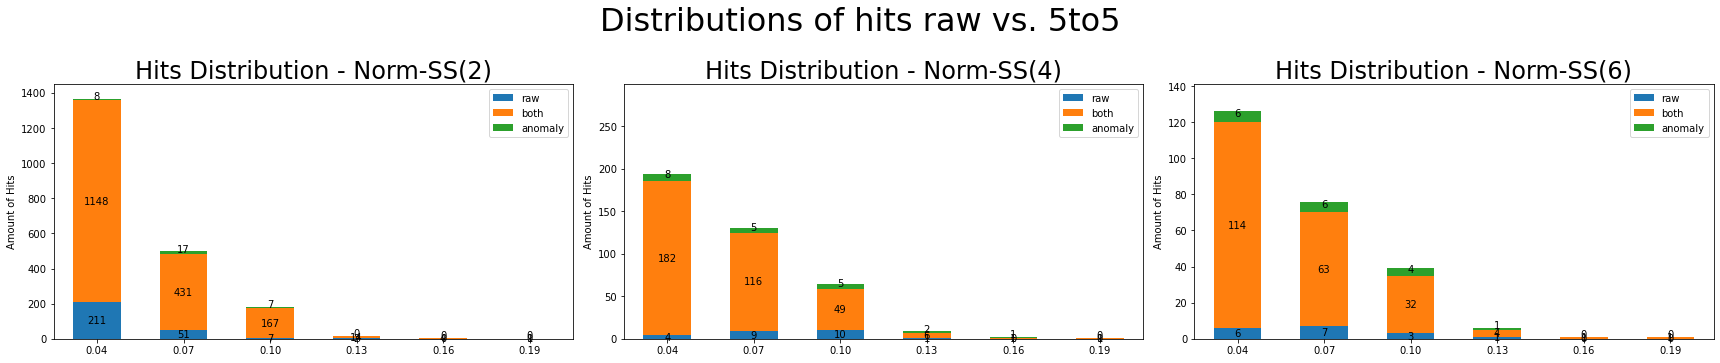

In [359]:
import matplotlib.pyplot as plt

for (mtd_a, mtd_b), cur_cs in cs.items():
    # try:
        # plot_complementary(chan, f'{methods[mtd_a]['name']} vs. {methods[mtd_b]['name']} - All', cur_cs, method_a=methods[mtd_a]['name'],method_b=methods[mtd_b]['name'])
    plot_complementary('raw vs. 5to5', cur_cs, method_a=methods[mtd_a]['name'],method_b=methods[mtd_b]['name'], save_dir=exp_save_dir)
    # except:
        # print('Problem with', 'raw vs. 5to5')

## Plot Sensitivity

### Scatter plot

In [360]:
# https://stackoverflow.com/questions/22104256/does-matplotlib-have-a-function-for-drawing-diagonal-lines-in-axis-coordinates
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

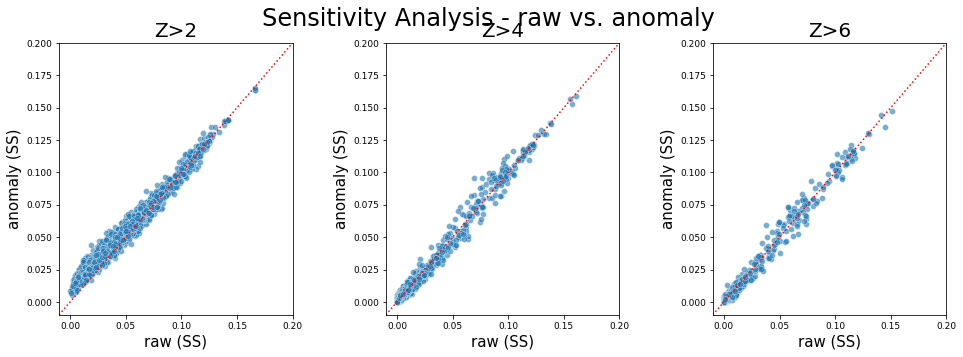

In [361]:
import seaborn as sns

ts = [2,4,6]
nrow = 1
ncol = 3


for mtd_a, mtd_b in combs:
    
    chan=''
    d={'xlabel':f'{name_a} (SS)', 'ylabel': f'{name_b} (SS)'}
    fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*5.3,nrow*5), subplot_kw=d, facecolor='white')
    fig.suptitle(f'Sensitivity Analysis - {name_a} vs. {name_b}', fontsize = 24)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    # for i, chan in enumerate(channels):
        # joined = ss_scores[mtd_a].join(ss_scores[mtd_b].filter(like=chan, axis=1), how='right', lsuffix=f'_{mtd_names[mtd_a]}', rsuffix=f'_{mtd_names[mtd_b]}')
    joined = methods[mtd_a]['ss'].join(methods[mtd_b]['ss'], how='right', lsuffix='_'+methods[mtd_a]['name'], rsuffix='_'+methods[mtd_b]['name'])
    for j, t in enumerate(ts):
        ax = axs[j]
        ax.set_title(f'Z>{t}')
        
        if len(chan)>0:
            _ = sns.scatterplot(data=joined, x=f'{chan}_SS_{t}_{name_b}', y=f'{chan}_SS_{t}_{name_a}', alpha=0.6, ax=ax)
        else:
            _ = sns.scatterplot(data=joined, x=f'SS_{t}_{name_b}', y=f'SS_{t}_{name_a}', alpha=0.6, ax=ax)

        add_identity(ax, color='r', ls=':')


        ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False,
                         bottom=True, top=False, left=True, right=False)
        ax.tick_params(axis='both', labelsize = 9)
        ax.yaxis.label.set_size(15)
        ax.xaxis.label.set_size(15)
        ax.title.set_size(20)

        # ax.set(xlim=(-0.01, 0.99), ylim=(-0.01, 0.99))
        ax.set(xlim=(-0.01, 0.2), ylim=(-0.01, 0.2))
        
            
    plt.show()
        # _ = fig.legend(symbols, zscores.keys(), markerscale=1.2, loc='center right')#, fontsize='xx-large')

    _ = fig.savefig(f'{exp_save_dir}/ss-raw-map.png', format='png')

In [410]:
joined

,,Rep_Cnt_raw,SS_2_raw,SS_4_raw,SS_6_raw,Rep_Cnt_anomaly,SS_2_anomaly,SS_4_anomaly,SS_6_anomaly
Metadata_broad_sample,,,,,,,,,
BRD-A00100033-001-04-8,0,8,0.094294,0.024608,0.003049,8,0.095819,0.030923,0.004573
BRD-A00267231-001-01-1,0,8,0.088850,0.011324,0.000218,8,0.093859,0.015462,0.000436
BRD-A00327403-103-01-9,0,8,0.061193,0.002831,0.000000,8,0.066855,0.002178,0.000000
BRD-A00520476-001-03-3,0,8,0.062064,0.000871,0.000000,8,0.064242,0.000218,0.000000
BRD-A00827783-001-04-8,0,8,0.035497,0.000218,0.000000,8,0.024608,0.000218,0.000000
...,...,...,...,...,...,...,...,...,...
BRD-K98157055-001-04-2,0,8,0.037456,0.004355,0.000000,8,0.031577,0.002831,0.000000
BRD-K98174813-001-05-7,0,8,0.058580,0.005662,0.000000,8,0.058362,0.003049,0.000000
BRD-K98281970-001-02-6,0,8,0.039634,0.005880,0.001089,8,0.039416,0.005444,0.000653


### Violin plot 

In [362]:
results = []
for method in methods.keys():

    # res = (ss_scores[method].filter(like=f'{chan}_SS', axis=1).rename(lambda x: x.split('_')[-1], axis=1)).melt(var_name='Threshold', value_name='SS')
    res = (methods[method]['ss'].rename(lambda x: x.split('_')[-1], axis=1)).melt(var_name='Threshold', value_name='SS')
    # res['Channel'] = 'ALL'
    res['Method'] = method
    results.append(res)

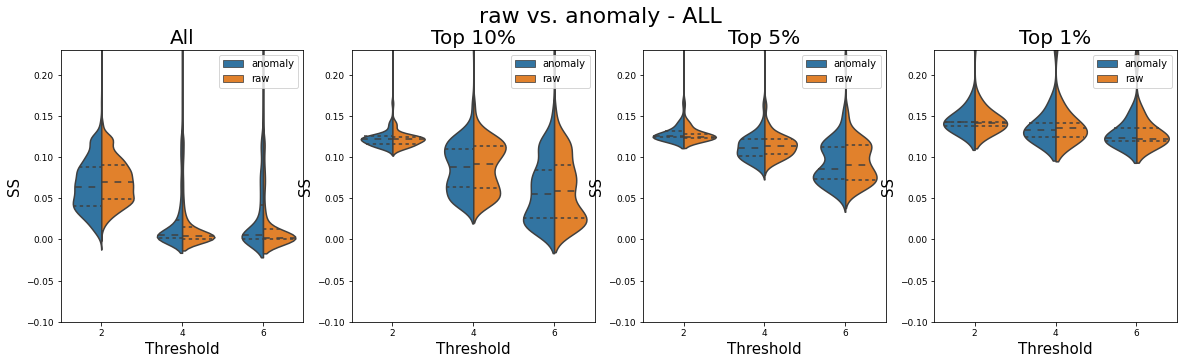

<Figure size 432x288 with 0 Axes>

In [364]:
nrow = 1
ncol = len(percentiles)

d={'xlabel':"Threshold", 'ylabel':"SS"}
titles = ['All', 'Top 10%', 'Top 5%','Top 1%']

chan = 'ALL'


for mtd_a, mtd_b in combs:
    
    # name_a = methods[mtd_a]['name']
    # name_b = methods[mtd_b]['name']
    
    cur_data = data[data.Method.isin([mtd_a,mtd_b])]
    cur_data = cur_data[cur_data.Threshold.isin([str(i) for i in [2, 4, 6, 10, 14]])]
    # cur_data.Method = cur_data.Method.replace(methods.keys())
    # cur_data = cur_data[cur_data.Channel==chan]
    thresholds = cur_data.Threshold.unique()
    cur_methods = cur_data.Method.unique()

    fig, ax = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*5,nrow*5), subplot_kw=d, facecolor='white')
    fig.suptitle(f'{mtd_a} vs. {mtd_b} - {chan}', fontsize=22, y=1)


    for i, p in enumerate(percentiles):

        data_outliers = pd.DataFrame()
        for t in thresholds:
            data_t = cur_data[cur_data['Threshold']==t]
            for j, m in enumerate(cur_methods):
                # print(m)
                data_m = data_t[data_t['Method']==m]
                # data_m.head()
                quantile = data_m['SS'].quantile(p)
                # print(quantile)
                data_m_outliers = data_m[data_m['SS']>quantile]  
                data_outliers = pd.concat([data_outliers, data_m_outliers])

        # _ = sns.boxplot(data=data_outliers, x='Threshold', y='SS',hue='Method', palette="Set2",ax=ax[i])
        _ = sns.violinplot(data=data_outliers, x='Threshold', y='SS', hue='Method', ax=ax[i], split=True, inner='quartile')
        del data_outliers

        ax[i].set_title(titles[i])
        ax[i].tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False,
                         bottom=True, top=False, left=True, right=False)
        ax[i].tick_params(axis='both', labelsize = 9)
        ax[i].yaxis.label.set_size(15)
        ax[i].xaxis.label.set_size(15)
        ax[i].title.set_size(20)
        ax[i].legend(loc='upper right')

        ax[i].set(ylim=(-0.1, 0.23))
        
    plt.show()
    plt.tight_layout()
    _ = fig.savefig(f'{exp_save_dir}/violin-raw-map.png', format='png')
        
    

#     _ = fig.savefig(f'/sise/assafzar-group/g-and-n/tabular_models_results/plots/sensitivity/{mtd_names[mtd_a]} vs {mtd_names[mtd_b]} - ALL.png', format='png')
#     _ = fig.savefig(f'/sise/assafzar-group/g-and-n/tabular_models_results/plots/sensitivity/{mtd_names[mtd_a]} vs {mtd_names[mtd_b]} - ALL.eps', format='eps')


# Reproducibility

### Produce null disribution

In [475]:
cpds_med_score = {}
for m in methods.keys():
    cpds_med_score[m] = get_replicates_score(methods[m]['zscores'],methods[m]['features'])

cpds_score_df_trt = pd.DataFrame({k[:]: v for k, v in cpds_med_score.items()})
cpds_score_df_trt.head()

,anomaly,raw
BRD-K18250272-003-03-7,0.295153,0.262042
BRD-K18316707-001-01-9,0.318973,0.291089
BRD-K18438502-001-02-6,0.079262,0.043511
BRD-K18550767-001-02-8,0.224777,0.121991
BRD-K18574842-323-03-3,0.295163,0.206553


In [ ]:
if not os.path.exists(null_dist_path):

    replicates_df, cpds = get_duplicate_replicates(methods[m]['zscores'],min_num_reps=4)
    null_distribution_replicates = get_null_distribution_replicates(replicates_df, cpds, rand_num=num_rand)
    
    # null_distribution_replicates.to_csv(f'null_distribution_replicates_{num_plates}.csv')
    with open(null_dist_path, 'wb') as handle:
        pickle.dump(null_distribution_replicates, handle, protocol=pickle.HIGHEST_PROTOCOL)

else:
    
    with open(null_dist_path, 'rb') as f:
        null_distribution_replicates = pickle.load(f)
        
len(null_distribution_replicates)

 53%|█████▎    | 1181/2239 [40:50<36:07,  2.05s/it] 

In [ ]:
duplicate_replicates = assert_null_distribution(null_distribution_replicates)
duplicate_replicates ## no replicates

## Calculate Median Scores P-values

In [ ]:
null_distribution_replicates['BRD-K18250272-003-03-7'][0]
# df_reps = df[df.index.get_level_values(2).isin(rep_list)]

In [ ]:
methods[m]['zscores'].index.get_level_values(2)

In [ ]:
null_distribution_medians = {}
# cpds_med_score[m]
for m in methods.keys():
    # methods[m]['null_distribution_medians'] = 
    null_distribution_medians_path = f'{null_distribution_medians_base_path}_{m}.pkl'
    if not os.path.exists(null_distribution_medians_path):
        methods[m]['null_distribution_medians'] = get_null_dist_median_scores(null_distribution_replicates, methods[m]['zscores'],methods[m]['features'])
    else:
        with open(null_distribution_medians_path, 'rb') as f:
            methods[m]['null_distribution_medians'] = pickle.load(f)
      
    # null_distribution_medians['raw1to1'] = get_null_dist_median_scores(null_distribution_replicates, cpd_raw1to1_trt)


In [ ]:
cpds_score_df_trt.head()
methods[m]['null_distribution_medians']['BRD-K17705806-003-01-0']

In [ ]:

df_null_p_vals = pd.DataFrame([])

for method in methods.keys():
    # null_distribution_medians = get_null_dist_median_scores(null_distribution_replicates, cpds_score_df_trt,method=method)
    
 
    methods[m]['null_p_vals']= get_moa_p_vals(methods[m]['null_distribution_medians'], cpds_score_df_trt, method=method)
    method_df_null_p_vals = pd.DataFrame.from_dict(methods[m]['null_p_vals'],orient='index',columns=[method])
    if len(df_null_p_vals)>0:
        df_null_p_vals = df_null_p_vals.join(method_df_null_p_vals)
    else:
        df_null_p_vals = method_df_null_p_vals.copy()
    
    # cpds_score_df_trt = cpds_score_df_trt.join(df_null_p_vals)

display(df_null_p_vals)

In [ ]:
medians = cpds_score_df_trt[methods.keys()].melt(var_name=["method"],value_name='median_score',ignore_index=False).reset_index()
p_vals = df_null_p_vals[methods.keys()].melt(var_name=["method"],value_name='p_val',ignore_index=False).reset_index()
# cpds_score_df_trt.to_csv(f'cpds_score_df_trt_{num_plates}.csv')
df_null_p_vals.to_csv(f'{output_dir}/df_null_p_vals_{num_rand}.csv')
# a = pd.merge(medians,p_vals, left_on=['index','median_score'], right_on=['index','p_val'])
percantage_replicating_df = pd.merge(medians,p_vals, on=['index','method'])
percantage_replicating_df.to_csv(f'{output_dir}/percentage_replicating_{num_rand}.csv') #, index=False, sep="\t")
    
percantage_replicating_df.head()

# Load results (PR and SS)
based on https://github.com/broadinstitute/lincs-profiling-complementarity/blob/master/1.Data-exploration/Profiles_level4/cell_painting/9.cellpainting-percent-replicating-subsampled-and-nonspherized.ipynb



In [409]:
import re
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
sns.set_style("darkgrid")
sns.set_context("talk")

In [129]:
# percantage_replicating_df = pd.read_csv('percentage_replicating_40.csv')
# percantage_replicating_df.method.value_counts()
# cpd_map_trt.head()

df_null_p_vals= pd.read_csv(f'{output_dir}/df_null_p_vals_{rand_num}.csv')
df_null_p_vals.rename( columns={'Unnamed: 0':'Metadata_broad_sample'}, inplace=True )

percantage_replicating_df = pd.read_csv(f'{output_dir}/percentage_replicating_{rand_num}.csv')
df_null_p_vals.head()


# df_null_p_vals.isna().sum()

# df_null_p_vals['map1'] = np.where(df_null_p_vals['map']<0.001,0.001,df_null_p_vals['map'])
# df_null_p_vals['raw1'] = np.where(df_null_p_vals['raw']<0.001,0.001,df_null_p_vals['raw'])
# df_null_p_vals['raw1to11'] = np.where(df_null_p_vals['raw1to1']<0,0.001,df_null_p_vals['raw1to1'])
# df_null_p_vals.isna().sum()


,Metadata_broad_sample,map,raw,raw1to1
0,BRD-A00100033-001-04-8,0.002,0.003,0.000
1,BRD-A00267231-001-01-1,0.031,0.000,0.005
2,BRD-A00327403-103-01-9,0.046,0.022,0.016
3,BRD-A00520476-001-03-3,0.141,0.087,0.058
4,BRD-A00827783-001-04-8,0.079,0.799,0.054


In [3]:
# load SS results
# map_res = pd.read_csv(f'/storage/users/g-and-n/tabular_models_results/30000/results/z_scores/ss_mas/map.csv', index_col=[0])
# raw_res = pd.read_csv(f'/storage/users/g-and-n/tabular_models_results/30000/results/z_scores/ss_mas/raw.csv', index_col=[0])
# raw1to1_res = pd.read_csv(f'/storage/users/g-and-n/tabular_models_results/30000/results/z_scores/ss_mas/raw1to1.csv', index_col=[0])

In [42]:
# merge map and raw
map_raw = pd.merge(map_res, raw_res,left_index=True, right_index=True, suffixes=('_map','_raw'))

# merge both with raw1to1
raw1to1_res=raw1to1_res.add_suffix('_raw1to1')
all_ss = pd.merge(map_raw,raw1to1_res,left_index=True, right_index=True)

# keep only 'All' results
all_ss = all_ss.filter(regex='ALL_')
all_ss.head()

,ALL_Med_Corr_map,ALL_SS_2_map,ALL_MAS_2_map,ALL_SS_3_map,ALL_MAS_3_map,ALL_SS_4_map,ALL_MAS_4_map,ALL_SS_5_map,ALL_MAS_5_map,ALL_SS_6_map,...,ALL_SS_16_raw1to1,ALL_MAS_16_raw1to1,ALL_SS_17_raw1to1,ALL_MAS_17_raw1to1,ALL_SS_18_raw1to1,ALL_MAS_18_raw1to1,ALL_SS_19_raw1to1,ALL_MAS_19_raw1to1,ALL_SS_20_raw1to1,ALL_MAS_20_raw1to1
Metadata_broad_sample,,,,,,,,,,,,,,,,,,,,,
BRD-A00037023-001-05-1,0.263927,113.750,0.269288,41.250,0.162164,13.500,0.092770,5.250,0.057852,3.50,...,0.000,0.000000,0.00,0.00000,0.000,0.000000,0.000,0.000000,0.000,0.000000
BRD-A00051892-001-05-0,0.209897,77.000,0.197582,22.250,0.106211,7.500,0.061664,2.500,0.035602,1.25,...,0.000,0.000000,0.00,0.00000,0.000,0.000000,0.000,0.000000,0.000,0.000000
BRD-A00100033-001-04-8,0.052868,202.125,0.160659,129.375,0.128535,86.375,0.105024,59.375,0.087076,43.75,...,1.875,0.015775,1.25,0.01288,0.875,0.010776,0.375,0.007055,0.375,0.007055
BRD-A00214921-001-04-2,0.027105,110.250,0.084960,32.000,0.045772,10.500,0.026219,4.250,0.016681,1.75,...,0.000,0.000000,0.00,0.00000,0.000,0.000000,0.000,0.000000,0.000,0.000000
BRD-A00250346-001-05-0,0.181629,111.000,0.220676,43.750,0.138542,17.250,0.086994,8.500,0.061066,4.50,...,0.000,0.000000,0.00,0.00000,0.000,0.000000,0.000,0.000000,0.000,0.000000


In [411]:
joined.head()

,,Rep_Cnt_raw,SS_2_raw,SS_4_raw,SS_6_raw,Rep_Cnt_anomaly,SS_2_anomaly,SS_4_anomaly,SS_6_anomaly
Metadata_broad_sample,,,,,,,,,
BRD-A00100033-001-04-8,0,8,0.094294,0.024608,0.003049,8,0.095819,0.030923,0.004573
BRD-A00267231-001-01-1,0,8,0.088850,0.011324,0.000218,8,0.093859,0.015462,0.000436
BRD-A00327403-103-01-9,0,8,0.061193,0.002831,0.000000,8,0.066855,0.002178,0.000000
BRD-A00520476-001-03-3,0,8,0.062064,0.000871,0.000000,8,0.064242,0.000218,0.000000
BRD-A00827783-001-04-8,0,8,0.035497,0.000218,0.000000,8,0.024608,0.000218,0.000000


In [51]:
methods = ['map','raw','raw1to1']
t = [2,4,6,8]
for m in methods:
    all_ss_t = all_ss.filter(regex=f'SS_{t}_{m}')
    all_ss_t.head()
    
# all_ss.columns
# all_ss_t.rename(columns={f'ALL_SS_{t}_map':'map', f'ALL_SS_{t}_raw':'raw', f'ALL_SS_{t}_raw1to1':'raw1to1'},inplace=True)
# all_ss_t.head()
# ( columns={'Unnamed: 0':'Metadata_broad_sample'}, inplace=True )

,ALL_SS_2_map,ALL_SS_4_map,ALL_SS_6_map,ALL_SS_8_map,ALL_SS_2_raw,ALL_SS_4_raw,ALL_SS_6_raw,ALL_SS_8_raw,ALL_SS_2_raw1to1,ALL_SS_4_raw1to1,ALL_SS_6_raw1to1,ALL_SS_8_raw1to1
Metadata_broad_sample,,,,,,,,,,,,
BRD-A00037023-001-05-1,113.750,13.500,3.50,1.00,161.75,31.000,1.00,0.25,90.25,18.000,3.750,1.50
BRD-A00051892-001-05-0,77.000,7.500,1.25,0.25,88.00,1.000,0.00,0.00,88.00,4.750,1.250,0.25
BRD-A00100033-001-04-8,202.125,86.375,43.75,25.25,277.50,155.875,68.25,25.25,196.25,75.375,30.375,14.50
BRD-A00214921-001-04-2,110.250,10.500,1.75,0.75,139.00,13.500,1.00,0.00,128.75,9.750,0.750,0.50
BRD-A00250346-001-05-0,111.000,17.250,4.50,1.50,159.00,26.750,1.50,0.25,128.50,27.500,6.250,2.25


In [414]:
df_null_p_vals.keys()

'anomaly'

In [415]:
# add fields of log p_vals 
for m in df_null_p_vals.keys():
    df_null_p_vals[m] = np.where(df_null_p_vals[m]<0.001,0.001,df_null_p_vals[m])
    # df_null_p_vals['raw'] = np.where(df_null_p_vals['raw']<0.001,0.001,df_null_p_vals['raw'])
    # df_null_p_vals['raw1to1'] = np.where(df_null_p_vals['raw1to1']<0.001,0.001,df_null_p_vals['raw1to1'])
    # df_null_p_vals['raw_log'] = - np.log10(df_null_p_vals['raw'])
    # df_null_p_vals['raw1to1_log'] = - np.log10(df_null_p_vals['raw1to1'])

    df_null_p_vals[f'{m}_log'] = - np.log10(df_null_p_vals[m])
    # df_null_p_vals['raw_log'] = - np.log10(df_null_p_vals['raw'])
    # df_null_p_vals['raw1to1_log'] = - np.log10(df_null_p_vals['raw1to1'])
    df_null_p_vals.isna().sum()
# df_null_p_vals['map_log-raw_log'] = df_null_p_vals['map_log']-df_null_p_vals['raw_log']
# df_null_p_vals['map_log-raw1to1_log'] = df_null_p_vals['map_log']-df_null_p_vals['raw1to1_log']

In [436]:
df_null_p_vals.head()
# joined.head()

,anomaly,raw,anomaly_log,raw_log
BRD-A00100033-001-04-8,0.5,0.5,0.301030,0.30103
BRD-A00267231-001-01-1,0.1,0.1,1.000000,1.00000
BRD-A00327403-103-01-9,0.2,0.5,0.698970,0.30103
BRD-A00520476-001-03-3,1.0,1.0,-0.000000,-0.00000
BRD-A00827783-001-04-8,0.7,0.5,0.154902,0.30103


In [437]:
percantage_replicating_df_non_melt = pd.merge(joined,df_null_p_vals, left_on='Metadata_broad_sample',right_index=True,suffixes=('','_p_val'))
percantage_replicating_df_non_melt.head()
percantage_replicating_df_non_melt.isna().sum()

Rep_Cnt_raw        0
SS_2_raw           0
SS_4_raw           0
SS_6_raw           0
Rep_Cnt_anomaly    0
SS_2_anomaly       0
SS_4_anomaly       0
SS_6_anomaly       0
anomaly            0
raw                0
anomaly_log        0
raw_log            0
dtype: int64

In [438]:
# SS = all_ss_t.melt(var_name=["method"],value_name='SS',ignore_index=False).reset_index()
# SS.head()
percantage_replicating_df_non_melt

,,Rep_Cnt_raw,SS_2_raw,SS_4_raw,SS_6_raw,Rep_Cnt_anomaly,SS_2_anomaly,SS_4_anomaly,SS_6_anomaly,anomaly,raw,anomaly_log,raw_log
Metadata_broad_sample,,,,,,,,,,,,,
BRD-A00100033-001-04-8,0,8,0.094294,0.024608,0.003049,8,0.095819,0.030923,0.004573,0.500,0.500,0.301030,0.30103
BRD-A00267231-001-01-1,0,8,0.088850,0.011324,0.000218,8,0.093859,0.015462,0.000436,0.100,0.100,1.000000,1.00000
BRD-A00327403-103-01-9,0,8,0.061193,0.002831,0.000000,8,0.066855,0.002178,0.000000,0.200,0.500,0.698970,0.30103
BRD-A00520476-001-03-3,0,8,0.062064,0.000871,0.000000,8,0.064242,0.000218,0.000000,1.000,1.000,-0.000000,-0.00000
BRD-A00827783-001-04-8,0,8,0.035497,0.000218,0.000000,8,0.024608,0.000218,0.000000,0.700,0.500,0.154902,0.30103
...,...,...,...,...,...,...,...,...,...,...,...,...,...
BRD-K98157055-001-04-2,0,8,0.037456,0.004355,0.000000,8,0.031577,0.002831,0.000000,0.001,0.001,3.000000,3.00000
BRD-K98174813-001-05-7,0,8,0.058580,0.005662,0.000000,8,0.058362,0.003049,0.000000,0.001,0.001,3.000000,3.00000
BRD-K98281970-001-02-6,0,8,0.039634,0.005880,0.001089,8,0.039416,0.005444,0.000653,0.001,0.001,3.000000,3.00000


# Plot results
based on https://github.com/broadinstitute/lincs-profiling-complementarity/blob/master/1.Data-exploration/Profiles_level4/cell_painting/9.cellpainting-percent-replicating-subsampled-and-nonspherized.ipynb



0.6426976328718178
0.5475658776239393


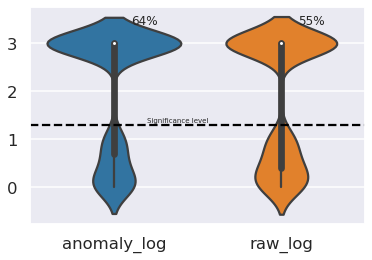

In [439]:
percantage_replicating_df_non_melt.head()

log_methods = [m +'_log' for m in methods]
# percantage_replicating_df_non_melt[log_methods].head()
fig = sns.violinplot(data=percantage_replicating_df_non_melt[log_methods])
log_val = -np.round(np.log10(0.05),5)
fig.axhline(log_val, ls='--', c='black')
# fig.legend(loc = 'lower right')
fig.text(0.2,0.05+log_val, "Significance level",fontsize=7)
for i, m in enumerate(log_methods):
        repre = percantage_replicating_df_non_melt[percantage_replicating_df_non_melt[m]>log_val][m].count()/len(percantage_replicating_df_non_melt)
        print(repre)
        fig.text(0.1+i, 3.4,str(int(np.round(repre,2)*100))+'%', fontsize=12) #add text
# [m +'_log' for m in methods]


0.11434482329517172
0.11478658536585364
0.9642857142857143
0.9553571428571429


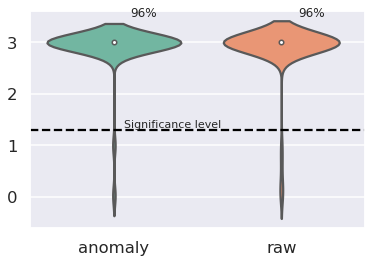

anomaly    0
raw        0
dtype: int64

In [442]:
violin = {}
ts = [2,6]
t= 2
quantile = 0.95
ind={}
# for ax, method in zip(dis_plt.axes.flat, methods):
        # ax.text(0.1, 300,'Reproducable replicates: '+str(int(np.round(repr_score[method],2)*100))+'%', fontsize=15)
for m in methods:
    quantile = percantage_replicating_df_non_melt[f'SS_{t}_{m}'].quantile(quantile)
    print(quantile)
    violin[m] = percantage_replicating_df_non_melt[percantage_replicating_df_non_melt[f'SS_{t}_{m}']>quantile][f'{m}_log'].values
    ind[m] = percantage_replicating_df_non_melt[percantage_replicating_df_non_melt[f'SS_{t}_{m}']>quantile][f'{m}_log'].index
    
violin_df = pd.DataFrame(violin)
fig=sns.violinplot(data=violin_df, palette="Set2")
log_val = -np.round(np.log10(0.05),5)
fig.axhline(log_val, ls='--', c='black')
# fig.legend(loc = 'lower right')
fig.text(0.06,0.05+log_val, "Significance level",fontsize=11)
for i, m in enumerate(methods):
        repre = violin_df[violin_df[m]>log_val][m].count()/len(violin_df)
        print(repre)
        fig.text(0.1+i, 3.5,str(int(np.round(repre,2)*100))+'%', fontsize=12) #add text
plt.show()
violin_df.isna().sum()
# violin_df.head()

0.12491724738675956
0.12533038825286197
23
23
1.0
22
23
0.9565217391304348


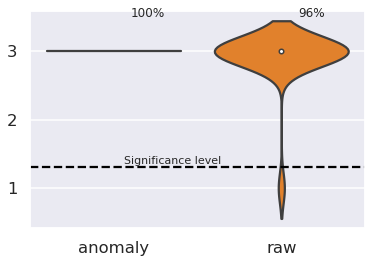

In [467]:
violin = {}
ind2={}
quantile_val = 0.99
# ts = [2,6]
t = 2

# for ax, method in zip(dis_plt.axes.flat, methods):
#         ax.text(0.1, 300,'Reproducable replicates: '+str(int(np.round(repr_score[method],6)*100))+'%', fontsize=15)
for m in methods:
    quantile = percantage_replicating_df_non_melt[f'SS_{t}_{m}'].quantile(quantile_val)
    print(quantile)
    violin[m] = percantage_replicating_df_non_melt[percantage_replicating_df_non_melt[f'SS_{t}_{m}']>quantile][f'{m}_log'].values
    ind2[m] = percantage_replicating_df_non_melt[percantage_replicating_df_non_melt[f'SS_{t}_{m}']>quantile][f'{m}_log'].index
violin_df = pd.DataFrame(violin)
fig=sns.violinplot(data=violin_df)

log_val = -np.round(np.log10(0.05),5)
fig.axhline(log_val, ls='--', c='black')
# fig.legend(loc = 'lower right')
fig.text(0.06,0.05+log_val, "Significance level",fontsize=11)
for i, m in enumerate(methods):
        
        repre = violin_df[violin_df[m]>log_val][m].count()/len(violin_df)
        print(violin_df[violin_df[m]>log_val][m].count())
        print(len(violin_df))
        print(repre)
        fig.text(0.1+i, 3.5,str(int(np.round(repre,2)*100))+'%', fontsize=12) #add text
plt.show()


In [444]:
print(ind[m])
print(ind2[m])

MultiIndex([('BRD-A17065207-001-06-9', 0),
            ('BRD-A18497530-001-04-6', 0),
            ('BRD-A19134330-001-03-8', 0),
            ('BRD-A22783572-065-01-3', 0),
            ('BRD-A23723433-001-01-2', 0),
            ('BRD-A26222320-001-02-6', 0),
            ('BRD-A34806832-001-02-7', 0),
            ('BRD-A37828317-001-02-2', 0),
            ('BRD-A40022950-001-02-9', 0),
            ('BRD-A43076080-001-03-3', 0),
            ...
            ('BRD-K84595254-001-03-0', 0),
            ('BRD-K85015012-003-01-1', 0),
            ('BRD-K86727142-001-06-6', 0),
            ('BRD-K87904882-001-02-3', 0),
            ('BRD-K88677950-001-01-3', 0),
            ('BRD-K88741031-001-01-0', 0),
            ('BRD-K90382497-001-01-6', 0),
            ('BRD-K91370081-001-04-6', 0),
            ('BRD-K92093830-003-05-0', 0),
            ('BRD-K95435023-001-01-0', 0)],
           names=['Metadata_broad_sample', None], length=112)
MultiIndex([('BRD-A17065207-001-06-9', 0),
            ('BRD-

In [446]:
def rename_cols(df):
    'Rename columns from dose number to actual doses'
    
    df.sortname(columns= {'dose_1' : '0.04 uM', 'dose_2':'0.12 uM', 'dose_3':'0.37 uM',
                        'dose_4': '1.11 uM', 'dose_5':'3.33 uM', 'dose_6':'10 uM'}, inplace = True)
    return df

def melt_df(df, col_name):
    """
    This function returns a reformatted dataframe with 
    3 columns: cpd, dose number and dose_values(median score or p-value)
    """
    # df = df.melt(id_vars=['cpd', 'no_of_replicates'], var_name="dose", value_name=col_name)
    df = df.melt(id_vars=['cpd'], var_name="p_val", value_name=col_name)
    return df

def merge_p_median_vals(df_cpd_vals, df_null):
    """
    This function merge p_values and median scores 
    dataframes for each compound for all doses(1-6) 
    """
    df_p_vals = melt_df(df_null, 'p_values')
    df_cpd_vals = melt_df(df_cpd_vals, 'median_scores')
    df_cpd_vals['p_values'] = df_p_vals['p_values']
    return df_cpd_vals


In [447]:
def plot_p_vs_median(df, path, file_name,x_col="fraction_score"):
    
    """plot p_values vs median correlation scores for each compound for all doses (1-6)"""
    
    if not os.path.exists(path):
        os.mkdir(path)
    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(12,8)) 
    plt.xlabel("Median scores of pairwise correlation btw cpds")
    plt.ylabel("Non-parametric P-values")
    plt.title("P-values vs median scores for compound replicates")
    # fig = sns.scatterplot(data=df, x="median_scores", y="p_values", hue="dose", 
    #                       style="dose", palette = "viridis")
    fig = sns.scatterplot(data=df, x=x_col, y="p_val", hue="method", 
                      style="method", palette = "viridis",alpha=0.5)

    fig.axhline(0.05, ls='--', c='black')
    fig.legend(loc = 'upper right')
    fig.text(-0.18,0.07, "Significance level (0.05)")
    plt.savefig(os.path.join(path, file_name))
    plt.show()

In [448]:
percantage_replicating_df[percantage_replicating_df['Metadata_broad_sample']=='BRD-K18250272-003-03-7']
# percantage_replicating_df.columns

KeyError: 'Metadata_broad_sample'

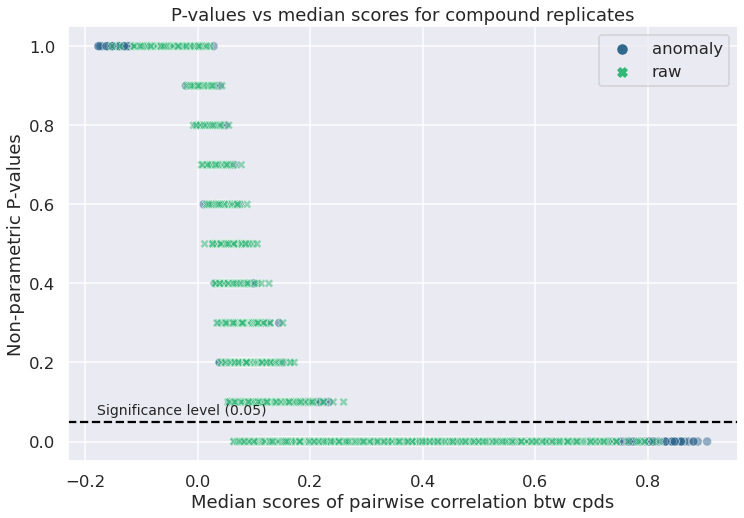

In [451]:
# percantage_replicating_df = percantage_replicating_df[percantage_replicating_df['method']!='raw1to1']

plot_p_vs_median(percantage_replicating_df,'cellpainting_figures', 'p_vs_median.png',x_col="median_score")
# plot_p_vs_median(percantage_replicating_df,'cellpainting_figures', 'p_vs_fraction.png', x_col="fraction_score")

In [452]:
def plot_p_vs_median(df, path, file_name,x_col="fraction_score"):
    
    """plot p_values vs median correlation scores for each compound for all doses (1-6)"""
    
    if not os.path.exists(path):
        os.mkdir(path)
    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(12,8)) 
    plt.xlabel(f"{x_col} scores of pairwise correlation btw cpds")
    plt.ylabel("Non-parametric -log10 P-values")
    plt.title(f"P-values vs {x_col} scores for compound replicates")
    # fig = sns.scatterplot(data=df, x="median_scores", y="p_values", hue="dose", 
    #                       style="dose", palette = "viridis")
    fig = sns.scatterplot(data=df, x=x_col, y="log10_p_val", hue="method", 
                      style="method", palette = "viridis",alpha=0.5)
    
    
    log_val = -np.round(np.log10(0.05),5)
    fig.axhline(log_val, ls='--', c='black')
    fig.legend(loc = 'lower right')
    if x_col == 'fraction_score':
        fig.text(0.2,0.03+log_val, "Significance level: "+str(log_val))
    else:
        fig.text(-0.5,0.03+log_val, "Significance level: "+str(log_val))
    plt.savefig(os.path.join(path, file_name))
    plt.show()
    


ValueError: Could not interpret value `SS` for parameter `x`

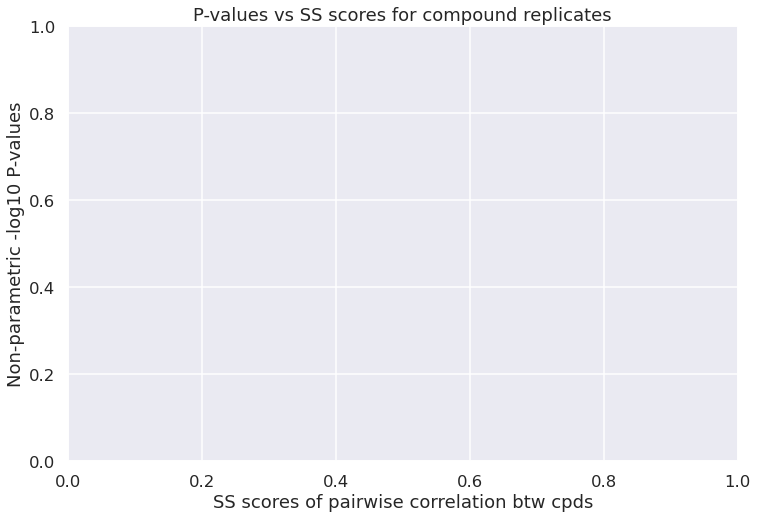

In [453]:
row_indices = percantage_replicating_df['p_val']<0.0001
percantage_replicating_df.loc[row_indices,'p_val']=0.0001
percantage_replicating_df['log10_p_val'] = - np.log10(percantage_replicating_df['p_val'])

plot_p_vs_median(percantage_replicating_df,'cellpainting_figures', 'p_vs_ss_log.png',x_col="SS")
# plot_p_vs_median(percantage_replicating_df,'cellpainting_figures', 'p_vs_fraction_log.png', x_col="fraction_score")
# plot_p_vs_median(percantage_replicating_df, 'cellpainting_figures', 'p_vs_median_log.png')
percantage_replicating_df.method.value_counts()

In [454]:
def plot_score_distribution(df, title, path, file_name, x='p_val'):
    
    if not os.path.exists(path):
        os.mkdir(path)
        
    dis_plt = sns.displot(df, x=x, hue="method", kind="hist", 
                          multiple="stack", palette = 'viridis', height=6.5, aspect=1.7)
    dis_plt.fig.suptitle(title)
    dis_plt.fig.subplots_adjust(top=.92)
    plt.savefig(os.path.join(path, file_name))
    plt.show()
    

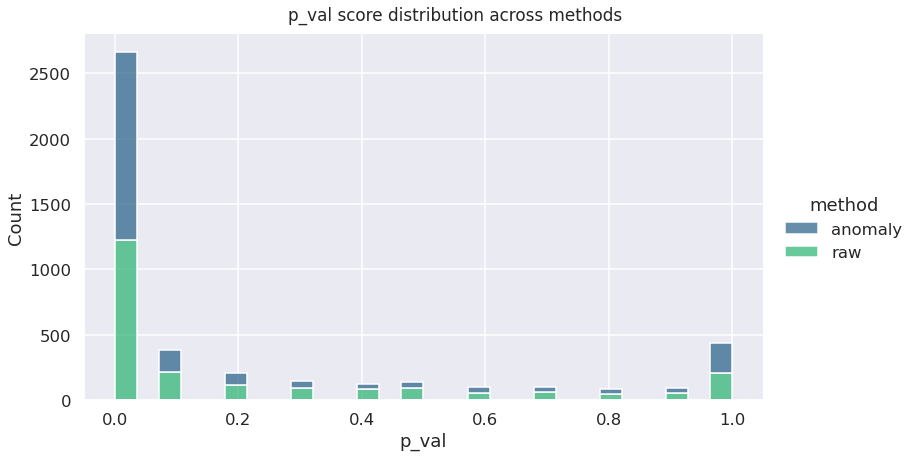

In [455]:
x_col = 'p_val'
plot_score_distribution(
    percantage_replicating_df,
    f"{x_col} score distribution across methods",
    'cellpainting_figures',
    'p_value_distribution_all.png',
    x='p_val'
)

In [463]:
percantage_replicating_df_non_melt.head()
percantage_replicating_df.head()
joined.head()

,,Rep_Cnt_raw,SS_2_raw,SS_4_raw,SS_6_raw,Rep_Cnt_anomaly,SS_2_anomaly,SS_4_anomaly,SS_6_anomaly
Metadata_broad_sample,,,,,,,,,
BRD-A00100033-001-04-8,0,8,0.094294,0.024608,0.003049,8,0.095819,0.030923,0.004573
BRD-A00267231-001-01-1,0,8,0.088850,0.011324,0.000218,8,0.093859,0.015462,0.000436
BRD-A00327403-103-01-9,0,8,0.061193,0.002831,0.000000,8,0.066855,0.002178,0.000000
BRD-A00520476-001-03-3,0,8,0.062064,0.000871,0.000000,8,0.064242,0.000218,0.000000
BRD-A00827783-001-04-8,0,8,0.035497,0.000218,0.000000,8,0.024608,0.000218,0.000000


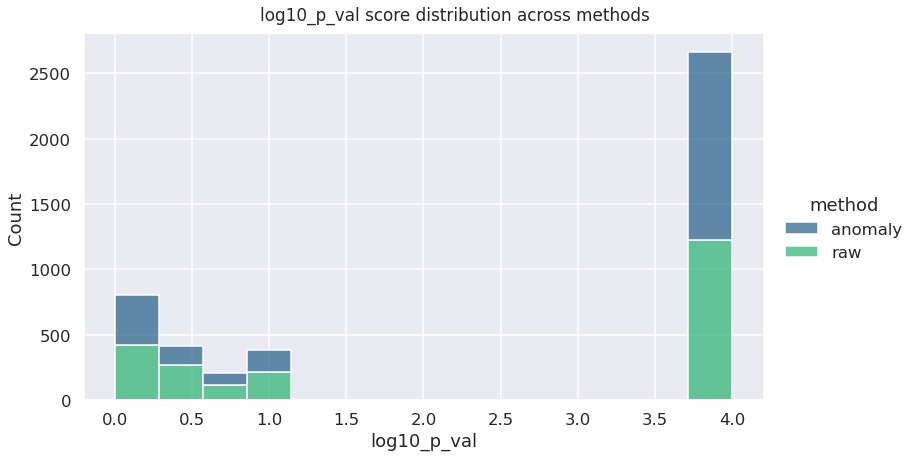

In [459]:
x_col = 'log10_p_val'
plot_score_distribution(
    percantage_replicating_df,
    f"{x_col} score distribution across methods",    
    'cellpainting_figures',
    'SS_score_distribution.png',
    x=x_col
)

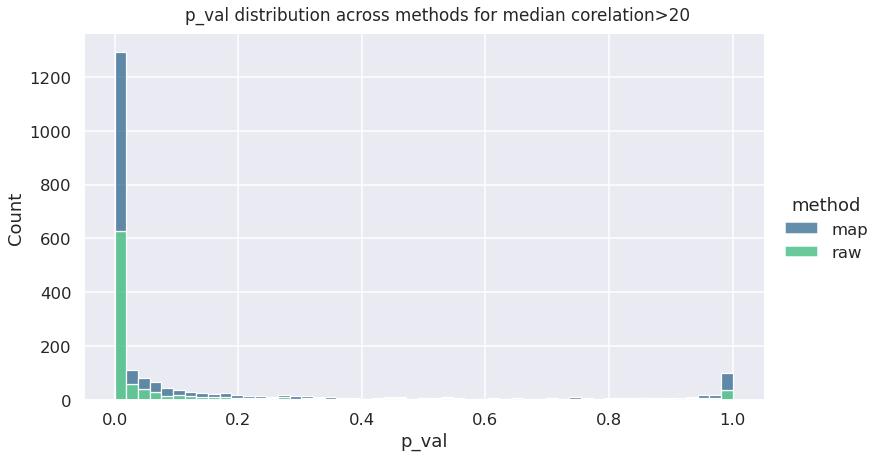

In [123]:
x = 'p_val'
median_threshold = 20
plot_score_distribution(
    percantage_replicating_df[percantage_replicating_df['SS']>median_threshold],
    f'p_val distribution across methods for median corelation>{median_threshold}',
    'cellpainting_figures',
    f'{x} stacked distribution for median corelation larger than {median_threshold}.png',
    x=x
)

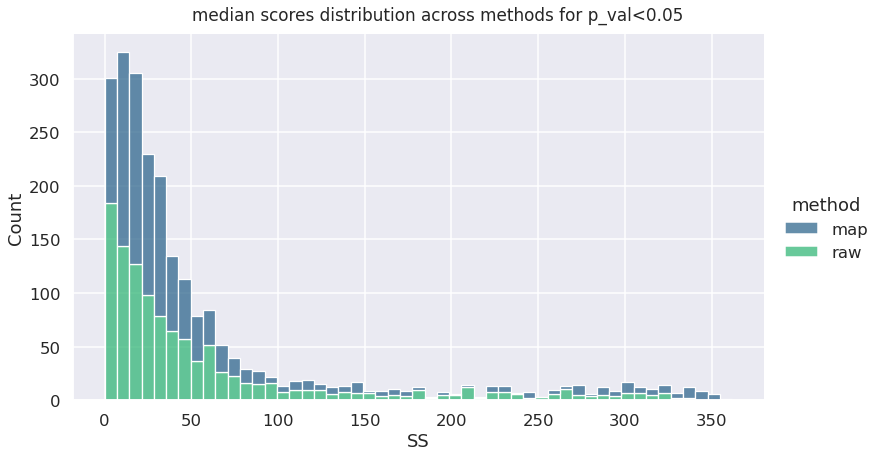

In [126]:
x='SS'
p_val_threshold = 0.05
plot_score_distribution(
    percantage_replicating_df[percantage_replicating_df['p_val']<p_val_threshold],
    f'median scores distribution across methods for p_val<{p_val_threshold}',
    'cellpainting_figures',
    f'{x}_stacked_distribution for p_val smaller than {p_val_threshold}.png',
    x=x
)


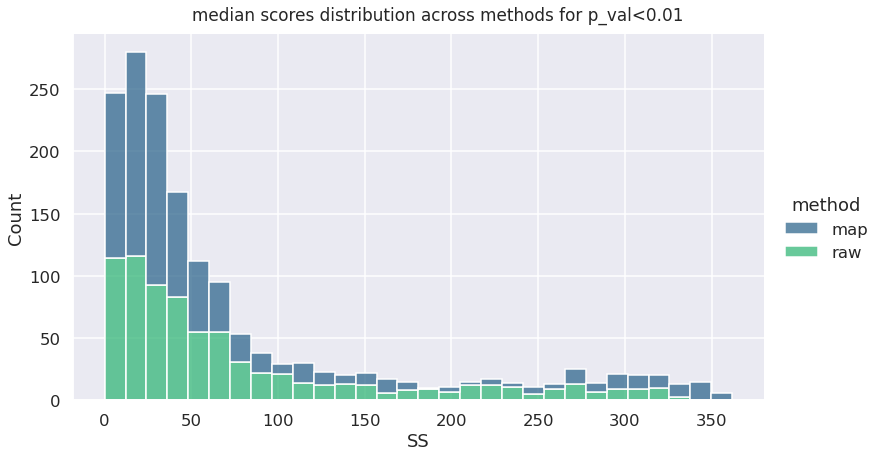

In [127]:
x='SS'
p_val_threshold = 0.01
plot_score_distribution(
    percantage_replicating_df[percantage_replicating_df['p_val']<p_val_threshold],
    f'median scores distribution across methods for p_val<{p_val_threshold}',
    'cellpainting_figures',
    f'{x}_stacked_distribution for p_val smaller than {p_val_threshold}.png',
    x=x
)

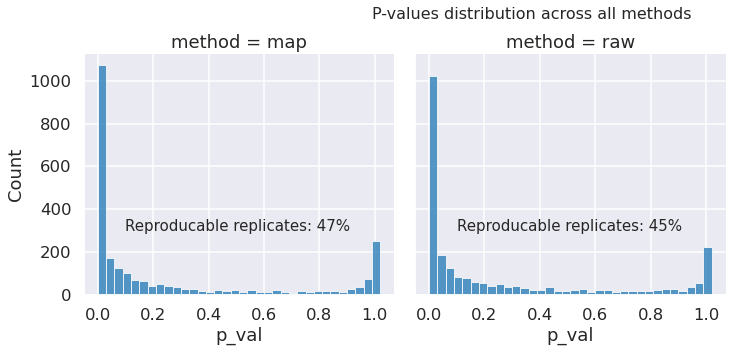

In [129]:
def plot_p_value_dist(df, path, file_name,thresh=0.05):
    """Plot p-values distribution"""
    if not os.path.exists(path):
        os.mkdir(path)  
    
    repr_score = {}
    methods = percantage_replicating_df.method.unique()
    for method in methods:
        df_method = percantage_replicating_df[percantage_replicating_df['method']==method]
        repr_score[method] = len(df_method[df_method['p_val']<=thresh])/ len(df_method)
    # repr_score
    dis_plt = sns.displot(df, x="p_val", col="method", col_wrap=3, binwidth=0.03)
    dis_plt.fig.suptitle("P-values distribution across all methods", size = 16)
    dis_plt.fig.subplots_adjust(top=.85)
    for ax, method in zip(dis_plt.axes.flat, methods):
        ax.text(0.1, 300,'Reproducable replicates: '+str(int(np.round(repr_score[method],2)*100))+'%', fontsize=15) #add text
    plt.savefig(os.path.join(path, file_name))
    plt.show()
    
plot_p_value_dist(percantage_replicating_df, 'cellpainting_figures', 'p_value_distribution_per_method.png',thresh=0.05)
repr_score = {}


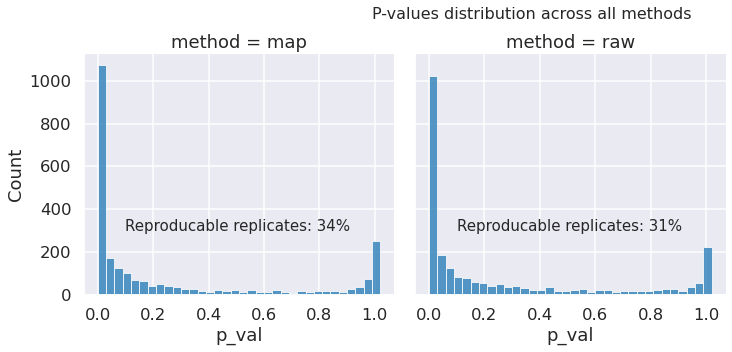

In [130]:
plot_p_value_dist(percantage_replicating_df, 'cellpainting_figures', 'p_value_distribution_per_method.png',thresh=0.01)
repr_score = {}

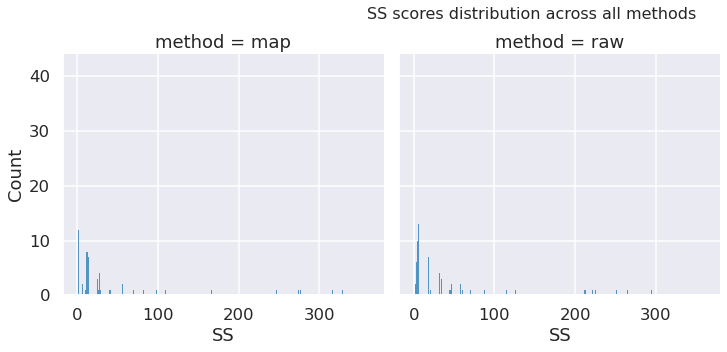

In [133]:
def plot_p_value_dist(df, path, file_name,x_col="fraction_score"):
    """Plot p-values distribution"""
    if not os.path.exists(path):
        os.mkdir(path)  
    dis_plt = sns.displot(df, x=x_col, col="method", col_wrap=3, binwidth=0.03)
    dis_plt.fig.suptitle(f"{x_col} scores distribution across all methods", size = 16)
    dis_plt.fig.subplots_adjust(top=.85)
    plt.savefig(os.path.join(path, file_name))
    plt.show()
                      
x_col="SS"
plot_p_value_dist(percantage_replicating_df, 'cellpainting_figures', f'{x_col}_score_distribution_per_method.png',x_col=x_col)

In [ ]:
def plot_p_value_dist(df, path, file_name,x_col="fraction_score", kind="kde"):
    """Plot p-values distribution"""
    if not os.path.exists(path):
        os.mkdir(path)  
    if kind=="kde":
        dis_plt = sns.displot(df, x=x_col, hue="method", kind=kind)
    elif kind=="hist":
        dis_plt = sns.histplot(df, x=x_col, hue="method",element="step", fill=False)
        # , multiple="dodge")
    elif kind == "ecdf":
        dis_plt = sns.ecdfplot(df, x=x_col, hue="method",stat="count", complementary=True)
    # dis_plt = sns.displot(df, x=x_col, col="method", col_wrap=3, binwidth=0.03)
    plt.title(f"{x_col} scores distribution across all methods", size = 16)
    plt.tight_layout()
    # dis_plt.subplots_adjust(top=.85)
    plt.savefig(os.path.join(path, file_name))
    plt.show()
                      
x_col="SS"
plot_p_value_dist(percantage_replicating_df, 
                  'cellpainting_figures', 
                  f'{x_col}_score_distribution_per_method.png',
                 kind="hist")

# ax = sns.barplot(x="day", y="total_bill", hue="sex", data=tips)

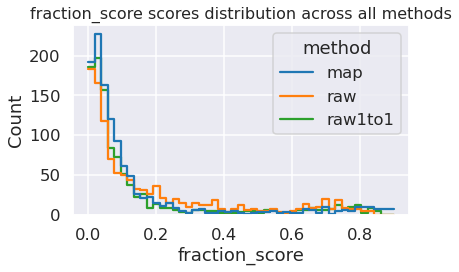

In [295]:
x='fraction_score'
p_val_threshold = 0.05
plot_p_value_dist(percantage_replicating_df[percantage_replicating_df['p_val']<p_val_threshold], 
                  'cellpainting_figures', 
                  f'{x_col}_score_distribution_per_method.png',
                 kind="hist")

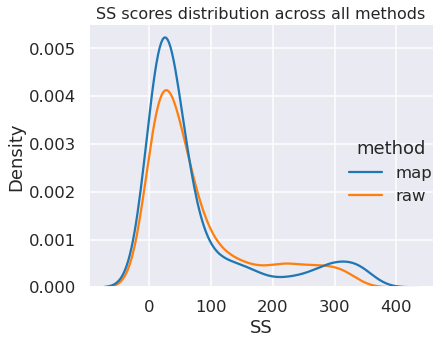

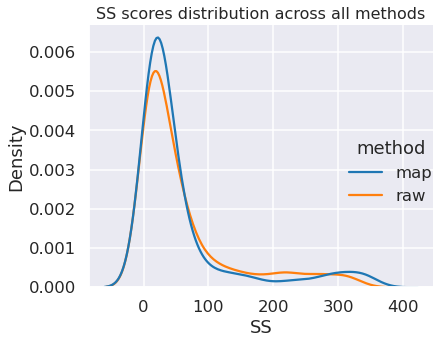

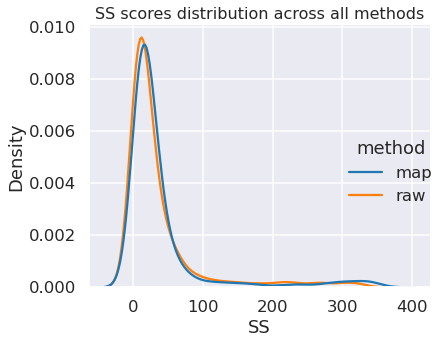

In [137]:
x='SS'

p_val_threshold = 0.01
plot_p_value_dist(percantage_replicating_df[percantage_replicating_df['p_val']<p_val_threshold], 
                  'cellpainting_figures', 
                  f'{x_col}_score_density for p_val smaller than {p_val_threshold}.png',
                 x_col=x)


p_val_threshold = 0.05
plot_p_value_dist(percantage_replicating_df[percantage_replicating_df['p_val']<p_val_threshold], 
                  'cellpainting_figures', 
                  f'{x_col}_score_density for p_val smaller than {p_val_threshold}.png',
                 x_col=x)

p_val_threshold = 1
plot_p_value_dist(percantage_replicating_df[percantage_replicating_df['p_val']<p_val_threshold], 
                  'cellpainting_figures', 
                  f'{x_col}_score_density for p_val smaller than {p_val_threshold}.png',
                 x_col=x)


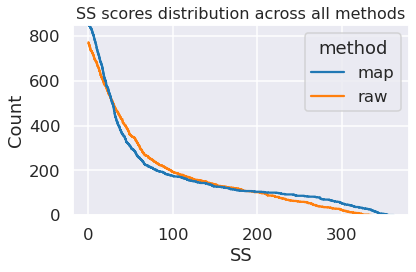

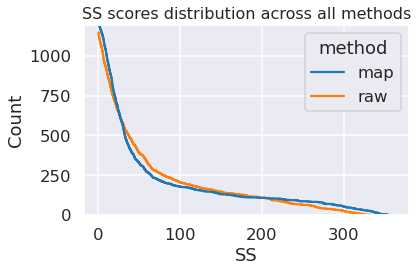

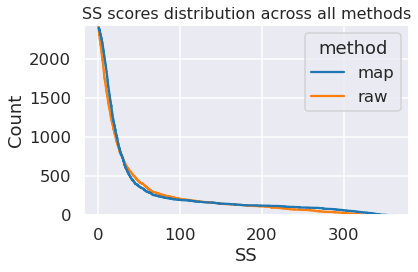

In [139]:
x='SS'

p_val_threshold = 0.01
plot_p_value_dist(percantage_replicating_df[percantage_replicating_df['p_val']<p_val_threshold], 
                  'cellpainting_figures', 
                  f'{x_col}_score ecdf for p_val smaller than {p_val_threshold}.png',
                 x_col=x
                  ,kind="ecdf")


p_val_threshold = 0.05
plot_p_value_dist(percantage_replicating_df[percantage_replicating_df['p_val']<p_val_threshold], 
                  'cellpainting_figures', 
                  f'{x_col}_score ecdf for p_val smaller than {p_val_threshold}.png',
                 x_col=x
                  ,kind="ecdf")

p_val_threshold = 1
plot_p_value_dist(percantage_replicating_df[percantage_replicating_df['p_val']<p_val_threshold], 
                  'cellpainting_figures', 
                  f'{x_col}_score ecdf for p_val smaller than {p_val_threshold}.png',
                 x_col=x
                  ,kind="ecdf")

In [205]:
# TODO
# 1. calc p-value for each cpd
# 2. plot graph
# 3. run for all plates
# 4. run on 1to1 and raw
# 4. add saving mechanisms
# 5. run for each scenario